In [22]:
# Step 1: Import Libraries
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [24]:
# Step 2: Extract ZIP
zip_path = 'letter+recognition.zip'
extract_to = './letter_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [26]:
# Step 3: Load Dataset
data_path = os.path.join(extract_to, 'letter-recognition.data')
column_names = ['letter', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar',
                'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege',
                'xegvy', 'y-ege', 'yegvx']


In [28]:
df = pd.read_csv(data_path, names=column_names)


In [30]:
# Encode labels
label_encoder = LabelEncoder()
df['letter'] = label_encoder.fit_transform(df['letter'])  # A=0, ..., Z=25

# Split features and labels
X = df.drop('letter', axis=1).values.astype(np.float32)
y = df['letter'].values.astype(np.int32)

In [32]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot
y_train_oh = tf.one_hot(y_train, depth=26)
y_test_oh = tf.one_hot(y_test, depth=26)


2025-05-02 11:58:52.544980: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [34]:
# Step 4: Build Model from Scratch (No Keras)
class DNNModel(tf.Module):
    def __init__(self):
        super().__init__()
        self.W1 = tf.Variable(tf.random.normal([16, 128], stddev=0.1), name='W1')
        self.b1 = tf.Variable(tf.zeros([128]), name='b1')
        self.W2 = tf.Variable(tf.random.normal([128, 64], stddev=0.1), name='W2')
        self.b2 = tf.Variable(tf.zeros([64]), name='b2')
        self.W3 = tf.Variable(tf.random.normal([64, 26], stddev=0.1), name='W3')
        self.b3 = tf.Variable(tf.zeros([26]), name='b3')

    def __call__(self, x):
        x = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
        x = tf.nn.relu(tf.matmul(x, self.W2) + self.b2)
        logits = tf.matmul(x, self.W3) + self.b3
        return logits

model = DNNModel()

In [36]:
# Step 5: Training Setup
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)


In [38]:
# Accuracy metric
def compute_accuracy(logits, labels):
    preds = tf.argmax(logits, axis=1)
    true = tf.argmax(labels, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, true), tf.float32))

In [42]:
# Step 6: Train Model (Corrected)
epochs = 30
batch_size = 64
train_size = X_train.shape[0]
steps_per_epoch = train_size // batch_size
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    for i in range(0, train_size, batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train_oh[i:i+batch_size]

        with tf.GradientTape() as tape:
            logits = model(X_batch)
            loss = loss_fn(y_batch, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        acc = compute_accuracy(logits, y_batch)
        epoch_loss += loss.numpy()
        epoch_acc += acc.numpy()

    avg_loss = epoch_loss / steps_per_epoch
    avg_acc = epoch_acc / steps_per_epoch
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {avg_acc:.4f}")


Epoch 1/30 - Loss: 1.7468 - Accuracy: 0.5445
Epoch 2/30 - Loss: 0.8170 - Accuracy: 0.7632
Epoch 3/30 - Loss: 0.6298 - Accuracy: 0.8154
Epoch 4/30 - Loss: 0.5194 - Accuracy: 0.8472
Epoch 5/30 - Loss: 0.4434 - Accuracy: 0.8696
Epoch 6/30 - Loss: 0.3870 - Accuracy: 0.8879
Epoch 7/30 - Loss: 0.3434 - Accuracy: 0.9021
Epoch 8/30 - Loss: 0.3085 - Accuracy: 0.9107
Epoch 9/30 - Loss: 0.2800 - Accuracy: 0.9189
Epoch 10/30 - Loss: 0.2566 - Accuracy: 0.9244
Epoch 11/30 - Loss: 0.2368 - Accuracy: 0.9297
Epoch 12/30 - Loss: 0.2197 - Accuracy: 0.9339
Epoch 13/30 - Loss: 0.2045 - Accuracy: 0.9381
Epoch 14/30 - Loss: 0.1910 - Accuracy: 0.9424
Epoch 15/30 - Loss: 0.1790 - Accuracy: 0.9465
Epoch 16/30 - Loss: 0.1681 - Accuracy: 0.9500
Epoch 17/30 - Loss: 0.1581 - Accuracy: 0.9527
Epoch 18/30 - Loss: 0.1491 - Accuracy: 0.9555
Epoch 19/30 - Loss: 0.1408 - Accuracy: 0.9576
Epoch 20/30 - Loss: 0.1330 - Accuracy: 0.9594
Epoch 21/30 - Loss: 0.1260 - Accuracy: 0.9617
Epoch 22/30 - Loss: 0.1194 - Accuracy: 0.96

In [44]:
# Step 7: Evaluate on Test Set
logits_test = model(X_test)
test_acc = compute_accuracy(logits_test, y_test_oh)
print(f"\nTest Accuracy: {test_acc.numpy():.4f}")


Test Accuracy: 0.9515


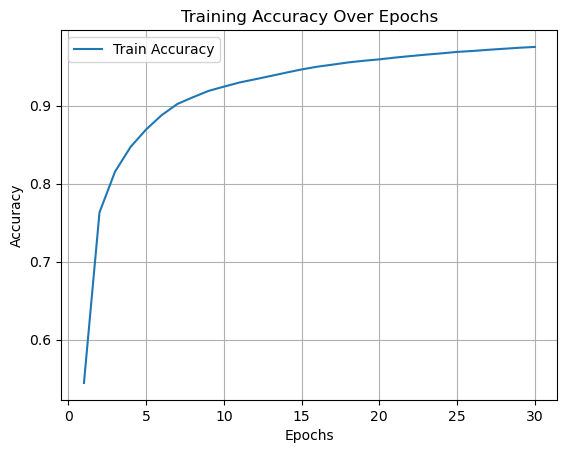

In [46]:
# Step 8: Plot Accuracy Curve
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.show()

In [48]:
# Step 9: Sample Predictions
sample_logits = model(X_test[:5])
sample_preds = tf.argmax(sample_logits, axis=1).numpy()
sample_true = y_test[:5]

print("\nSample Predictions:")
for i in range(5):
    pred_char = label_encoder.inverse_transform([sample_preds[i]])[0]
    true_char = label_encoder.inverse_transform([sample_true[i]])[0]
    print(f"Predicted: {pred_char}, Actual: {true_char}")


Sample Predictions:
Predicted: Z, Actual: T
Predicted: L, Actual: L
Predicted: A, Actual: A
Predicted: E, Actual: E
Predicted: Q, Actual: Q
